In [1]:
!pip install pysam

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [2]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import math
import glob
import sys
import os

import warnings
warnings.filterwarnings("ignore")

from pysam import VariantFile

## PCA on Genotypes

For the data, I used a different dataset than the original paper and a
different chromosome of the same dataset than Maria Nattestad used in her
implementation. If you are following along I also recommend you use a different
dataset or the same dataset and a different chromosome than either Maria
Nattestad (Chr 22) or I (Chr 21) used. This data is from the 1000 Genomes
Project [[2]](#2). If you with to reproduce my results either take a look at my
notebooks, or you can utilize my pipline and look at look at `USAGE.md` for
instructions.  The data I used can be downloaded via the following commands:

```
curl -O https://1000genomes.s3.amazonaws.com/release/20110521/ALL.chr21.phase1_release_v3.20101123.snps_indels_svs.genotypes.vcf.gz

curl -O https://1000genomes.s3.amazonaws.com/release/20110521/ALL.chr21.phase1_release_v3.20101123.snps_indels_svs.genotypes.vcf.gz.tbi

curl -O https://1000genomes.s3.amazonaws.com/release/20110521/phase1_integrated_calls.20101123.ALL.panel
```

**NOTE**: If you want to use a different chromosome you can simply just change
where the first two downloads say chr21 to chrx where x is the number of the
chromosome [1, 22].

In [ ]:
# If you would like to download the data using the above commands, you can run this block.

!curl -O https://1000genomes.s3.amazonaws.com/release/20110521/ALL.chr21.phase1_release_v3.20101123.snps_indels_svs.genotypes.vcf.gz
!curl -O https://1000genomes.s3.amazonaws.com/release/20110521/ALL.chr21.phase1_release_v3.20101123.snps_indels_svs.genotypes.vcf.gz.tbi
!curl -O https://1000genomes.s3.amazonaws.com/release/20110521/phase1_integrated_calls.20101123.ALL.panel

In [3]:
# I moved the above data to a file called "data/" in the current directory.
!tree ./data

./data
├── ALL.chr21.phase1_release_v3.20101123.snps_indels_svs.genotypes.vcf.gz
├── ALL.chr21.phase1_release_v3.20101123.snps_indels_svs.genotypes.vcf.gz.tbi
└── phase1_integrated_calls.20101123.ALL.panel

0 directories, 3 files


### Load the VCF Dataset

In [4]:
data_dir = "./data/"

vcf_dir   = os.path.join(data_dir, "ALL.chr21.phase1_release_v3.20101123.snps_indels_svs.genotypes.vcf.gz")
panel_dir = os.path.join(data_dir, "phase1_integrated_calls.20101123.ALL.panel")

# Parameter to save memory. Basically we only collect every n'th allele.
skip_every = 25

In [5]:
def allele_indices(vcf_dir, skip_every = 5):
    """
    Given a VCF file, this returns each samples genotype 
    represented as allele indices along with the corresponding
    variant IDs and list of samples.

    Args:
        vcf_dir (string): Location of VCF file.
        skip_every (int): Only return every other "skip_every"
            variant. This may be useful if you are running this
            with less than 16GB of RAM.

    Returns:
        list: List of each sample.
        list: Genotypes of shape: (samples, num_variants // skip_every, 2).
        list: Variant IDs for each variant.

    """
    vcf_file = VariantFile(vcf_dir)

    samples = list(vcf_file.header.samples)

    genotypes = []
    variant_ids = []
    for counter, record in tqdm(enumerate(vcf_file.fetch())):
        if counter % skip_every == 0:
            alleles = [record.samples[x].allele_indices for x in samples]

            genotypes.append(alleles)
            variant_ids.append(record.id)

    return samples, genotypes, variant_ids

def parse_panel(panel_dir):
    """
    Returns python dictionaries that maps each sample
    to a population and superpopulation. 

    Args:
        panel_dir (string): Location of the panel file 
            containing information about each sample.

    Returns:
        dict: Population map for each sample. For
            example, {sample_id, population}.

        dict: Superpopulation map for each sample. For
            example, {sample_id, superpopulation}.

    """
    population_map = {}  
    superpopulation_map = {}  
    with open(panel_dir) as panel_file:
        for sample in panel_file:
            """
            EX: ["HG00607", "CHS", "ASN", "ILLUMINA"]

            sample[0] = Sample ID.
            sample[1] = Population.
            sample[2] = Superpopulation.

            """
            sample = sample.strip().split('\t')

            population_map[sample[0]] = sample[1]
            superpopulation_map[sample[0]] = sample[2]
    
    return population_map, superpopulation_map 

# This may take ~1.5 minutes to run. 
samples, genotypes, variant_ids = allele_indices(vcf_dir, skip_every)
population_map, superpopulation_map = parse_panel(panel_dir)

# Find the superpopulation of each sample.
superpopulation = pd.Series(samples).map(superpopulation_map)

# Prepare the data for dimensionality reduction.
# shape: (samples, variant_count // skip_every, 2)
genotypes = np.array(genotypes)
genotypes = np.sum(genotypes, axis = 2)

0it [00:00, ?it/s]

In [6]:
# Due to kaggle notebooks not working well, further reduce the number 
# of dimensions of the data. In practice you don't have to do this because
# libraries will optimize the PCA implementation. Here, we are being very
# naive with how we perform PCA via SVD.

genotypes_small = genotypes[::10]

In [7]:
m, n = genotypes_small.shape

print(f"Shape: ({m}, {n})")
print(f"New Number of Alleles: {m}")
print(f"New Number of Sampled People: {n}")

Shape: (2076, 1092)
New Number of Alleles: 2076
New Number of Sampled People: 1092


### Compute the Covariance Matrix

In [8]:
# First mean normalize your data. That is,
# we substract the mean (dimension wise)
# which will center our data around the
# origin.

# Calculate the mean.
mean = np.mean(genotypes_small, axis = 1, keepdims = True)

# Subtract the mean.
genotypes_normalized = genotypes_small - mean

# Compute the covariance matrix of our data.
covariance = genotypes_normalized.dot(genotypes_normalized.T) / (n - 1)

### Dimensionality Reduction with PCA

In [9]:
eig_values, eig_vectors = np.linalg.eigh(covariance)

# They are in ascending order, we want the opposite.
eig_values = eig_values[::-1]
eig_vectors = eig_vectors[:, ::-1]

print(eig_values.shape)
print(eig_vectors.shape)

(2076,)
(2076, 2076)


In [10]:
# Testing how much variance is captured by in the dimensionality reduction.

np.cumsum(eig_values / np.sum(eig_values))[0 : 10]

array([0.0831045 , 0.13070515, 0.14289654, 0.15236331, 0.16062823,
       0.16877235, 0.17622259, 0.18349874, 0.19060836, 0.19756033])

In [11]:
# The eigenvalues are already sorted in descending
# order. Because the covariance matrix is positive
# semi-definite, s = d.T, and we can just take the
# leading two principle components straight from s. 

pc1 = eig_vectors[:, 0]
pc2 = eig_vectors[:, 1]

In [12]:
# Now we do a change of basis of our original data
# with our PC1 and PC2 forming the new space. This
# is the "dimensionality reduction" step. Because 
# the eigenvectors are of normal length, projecting
# out data onto this space is just a simple dot 
# product.

pc1_plot = genotypes_normalized.T.dot(pc1)
pc2_plot = genotypes_normalized.T.dot(pc2)

In [13]:
# Used to make the cover of the post, see `figures.ipynb`.
#np.save("pc1.npy", pc1_plot)
#np.save("pc2.npy", pc2_plot)
#superpopulation.to_csv("superpop.csv", index = False)

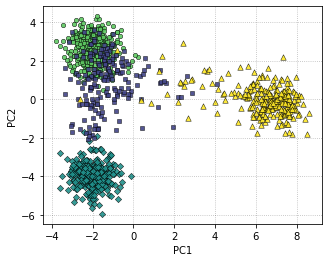

In [14]:
# Now lets visualize our dimensionality reduced data.

def plot(pc1, pc2, save_to = None):
    cmap = plt.get_cmap("viridis")
    plt.style.use("default")
    fig, ax = plt.subplots(1, 1, figsize = (5, 4))

    markers = ["o", "D", "s", "^"]
    sizes = np.array([10, 10, 10, 15]) * 2
    edges = np.array([0.1, 0.1, 0.1, 0.1]) * 5
    colors = [0.75, 0.5, 0.2, 1.0]

    i = 0
    for pop in superpopulation.unique():
        inds = superpopulation == pop
        ax.scatter(
            x = pc1[inds], 
            y = pc2[inds], 
            c = cmap(colors[i]),
            s = sizes[i],
            marker = markers[i],
            alpha = 0.9, 
            linewidth = edges[i],
            edgecolor = "black"
        )

        i += 1

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_facecolor('white')
    ax.grid(True, alpha = 0.3, color = "black", linestyle = "dotted", zorder = 1)
    
    if save_to is not None:
        plt.savefig(save_to, dpi = 300, facecolor = "white")

    plt.show()
    
plot(pc1_plot, pc2_plot, save_to = "figures/reduced_custom.png")

### Comparison with SKLearn

In [15]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components = 2)
pca_model.fit(genotypes_small.T)

pca_out = pca_model.transform(genotypes_small.T)
pca_out.shape

(1092, 2)

In [16]:
np.cumsum(pca_model.explained_variance_ratio_)

array([0.0831045 , 0.13070515])

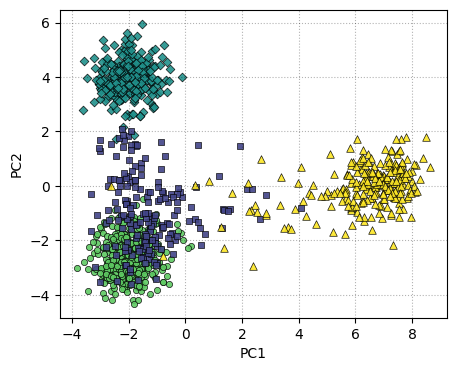

In [18]:
# Now lets visualize our dimensionality reduced data.

plot(pca_out[:, 0], pca_out[:, 1], save_to = "figures/reduced_scikit.png")

## Clustering on Reduced Data

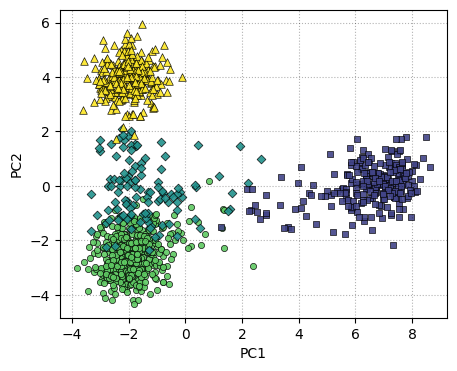

In [19]:
from sklearn.cluster import KMeans

pca_model = PCA(n_components = 128)

cluster_model = KMeans(n_clusters = 4, max_iter = 1000, n_init = 25)
cluster_model.fit(
    pca_model.fit_transform(genotypes.T)
)

cmap = plt.get_cmap("viridis")
plt.style.use("default")
fig, ax = plt.subplots(1, 1, figsize = (5, 4))

markers = ["o", "D", "s", "^"]
sizes = np.array([10, 10, 10, 15]) * 2
edges = np.array([0.1, 0.1, 0.1, 0.1]) * 5
colors = [0.75, 0.5, 0.2, 1.0]

i = 0
for cluster in np.unique(cluster_model.labels_):
    inds = cluster_model.labels_ == cluster
    ax.scatter(
        x = pca_out[inds, 0], 
        y = pca_out[inds, 1], 
        c = cmap(colors[i]),
        s = sizes[i],
        marker = markers[i],
        alpha = 0.9, 
        linewidth = edges[i],
        edgecolor = "black"
    )

    i += 1

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_facecolor('white')
ax.grid(True, alpha = 0.3, color = "black", linestyle = "dotted", zorder = 1)

plt.show()

In [20]:
variance_captured = np.cumsum(pca_model.explained_variance_ratio_)[-1]

print(f"Percentage of variance captured with {pca_model.n_components} components: {variance_captured:0.4f}")

Percentage of variance captured with 128 components: 0.4519


In [21]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

def _make_cost_m(cm):
    return -cm + np.max(cm)

def cluster_accuracy(y_pred, y_true):
    """
    Gets the best permutation accuracy score for 
    y_pred and y_true.
    
    """
    cm = confusion_matrix(y_pred, y_true)
    
    indexes = linear_sum_assignment(_make_cost_m(cm))
    
    total = 0
    for row, column in zip(*indexes):
        value = cm[row][column]
        total += value

    return (total * 1.0 / np.sum(cm))

In [22]:
true_values = superpopulation.map({
    "EUR": 0,
    "ASN": 1,
    "AMR": 2,
    "AFR": 3
}).values

cluster_accuracy(cluster_model.labels_, true_values)

0.9230769230769231